<a href="https://colab.research.google.com/github/ScientistLim/ProjectAW/blob/main/univariate_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

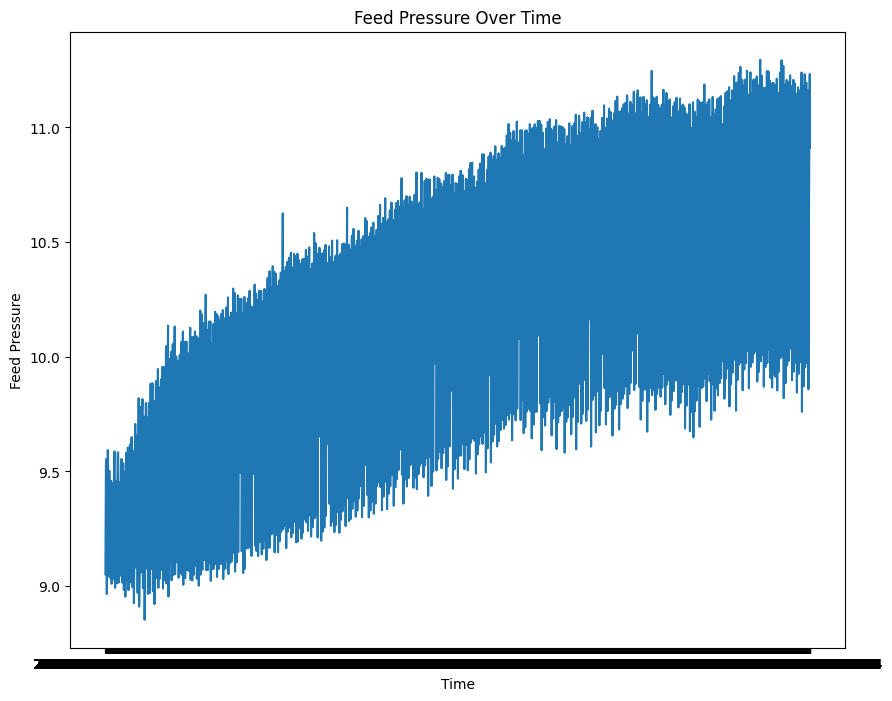

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 0.058400899171829224
Epoch 2/10, Loss: 0.0018475870601832867
Epoch 3/10, Loss: 0.0003187652037013322
Epoch 4/10, Loss: 0.0018636919558048248
Epoch 5/10, Loss: 0.004500820301473141
Epoch 6/10, Loss: 0.0033884295262396336
Epoch 7/10, Loss: 0.0016629532910883427
Epoch 8/10, Loss: 0.0037882633041590452
Epoch 9/10, Loss: 0.0045247990638017654
Epoch 10/10, Loss: 0.0021760822273790836


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


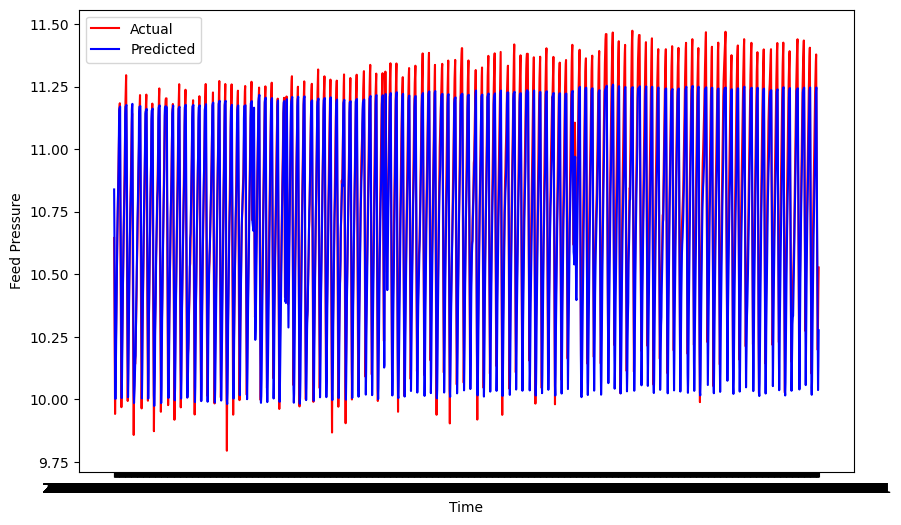

In [66]:
# 필요한 라이브러리 설치
!pip install torch numpy scikit-learn matplotlib

# 데이터 불러오기 및 전처리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 데이터 로드
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")

# 데이터 시각화
plt.figure(figsize=(10,8))
plt.plot(df_train["time"], df_train['feed_pressure'])
plt.xlabel("Time")
plt.ylabel("Feed Pressure")
plt.title("Feed Pressure Over Time")
plt.show()

# feed_pressure만 선택하여 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train[['feed_pressure']])

# 데이터셋 생성
sequence_length = 60
X_train, y_train = [], []

for i in range(sequence_length, len(df_train_scaled)):
    X_train.append(df_train_scaled[i-sequence_length:i])
    y_train.append(df_train_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

# Tensor 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Transformer 모델 정의
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim):
        super(TransformerTimeSeries, self).__init__()
        self.input_projection = nn.Linear(input_dim, model_dim)
        self.transformer_layer = nn.Transformer(
            d_model=model_dim, nhead=num_heads, num_encoder_layers=num_layers
        )
        self.fc_out = nn.Linear(model_dim, output_dim)

    def forward(self, x):
        x = self.input_projection(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, model_dim)
        x = self.transformer_layer(x, x)
        x = x.permute(1, 0, 2)
        return self.fc_out(x[:, -1, :])  # 최종 예측 값

# 모델 하이퍼파라미터
input_dim = 1
model_dim = 64
num_heads = 4
num_layers = 2
output_dim = 1
learning_rate = 0.001
num_epochs = 10

# 모델 초기화
model = TransformerTimeSeries(input_dim, model_dim, num_heads, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 모델 학습
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# 테스트 데이터 전처리
df_total = pd.concat((df_train['feed_pressure'], df_test['feed_pressure']), axis=0)
df_total_scaled = scaler.transform(df_total.values.reshape(-1, 1))

test_input = df_total_scaled[len(df_total_scaled) - len(df_test) - sequence_length:]
X_test = []

for i in range(sequence_length, len(test_input)):
    X_test.append(test_input[i-sequence_length:i])

X_test = np.array(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32)

# 예측
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()

# 스케일 복원
y_test_pred_actual = scaler.inverse_transform(y_test_pred)

# 시각화 및 평가
df_test['Predicted'] = y_test_pred_actual
plt.figure(figsize=(10, 6))
plt.plot(df_test["time"], df_test['feed_pressure'], color='red', label='Actual')
plt.plot(df_test["time"], df_test['Predicted'], color='blue', label='Predicted')
plt.xlabel("Time")
plt.ylabel("Feed Pressure")
plt.legend()
plt.show()

# 평가 지표
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

rmse = np.sqrt(mean_squared_error(df_test['feed_pressure'], df_test['Predicted']))
r2 = r2_score(df_test['feed_pressure'], df_test['Predicted'])
mape = mean_absolute_percentage_error(df_test['feed_pressure'], df_test['Predicted']) * 100

print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 (Coefficient of Determination):", r2)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")


In [ ]:
# 평가 지표
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
import numpy as np

# 기존 평가 지표 계산
rmse = np.sqrt(mean_squared_error(df_test['feed_pressure'], df_test['Predicted']))
r2 = r2_score(df_test['feed_pressure'], df_test['Predicted'])
mape = mean_absolute_percentage_error(df_test['feed_pressure'], df_test['Predicted']) * 100

# Pearson Correlation Coefficient 계산
pcc, _ = pearsonr(df_test['feed_pressure'], df_test['Predicted'])

# Mean Bias Deviation (MBD) 계산
mbd = np.mean(df_test['Predicted'] - df_test['feed_pressure'])

# Mean Absolute Error of Means (MAEM) 계산
maem = abs(np.mean(df_test['Predicted']) - np.mean(df_test['feed_pressure']))

# 결과 출력
print("Root Mean Squared Error (RMSE):", rmse)
print("R^2 (Coefficient of Determination):", r2)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")
print("Pearson Correlation Coefficient (PCC):", pcc)
print("Mean Bias Deviation (MBD):", mbd)
print("Mean Absolute Error of Means (MAEM):", maem)


Root Mean Squared Error (RMSE): 0.1534910847017862
R^2 (Coefficient of Determination): 0.842997593314833
Mean Absolute Percentage Error (MAPE): 1.236991039011071 %
